In [1]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral
from AaltoAtoms import get_perfect_circle_positions, minimize_manipulation_distance, lattice_discretize

from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg
import random

In [23]:
CC = Createc_Controller()

# get atoms at beginning
Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)
central_atom_loc = C.get_central_atom(C.centroids)

succeed to connect
	18 centroids


	Max height guess different from Gaussian fit on average by: 0.89 Å
	 2022-05-18 10:35:16.748417
	Central atom from Naive fit:  5.112192036497644 [64.21661315 54.44484944]
	Central atom from Gauss fit:  5.11483477558959 [64.60846299 54.88239984]


5.11483477558959

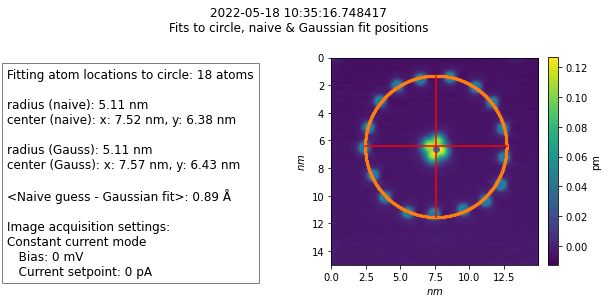

In [24]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1, savefig=False)

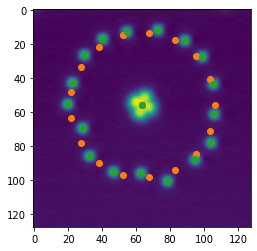

In [20]:
%matplotlib inline
radius_nm = 5

perfect_circle, center = get_perfect_circle_positions(radius_nm, C, True)
lattice_discretized_circle = lattice_discretize(perfect_circle, C.im.shape[0], C.xPix*C.ang_ppx_x/10.)
discretized_center = C.get_central_atom(lattice_discretized_circle)
center_to_discretized_center_difference = center - discretized_center

zero vector


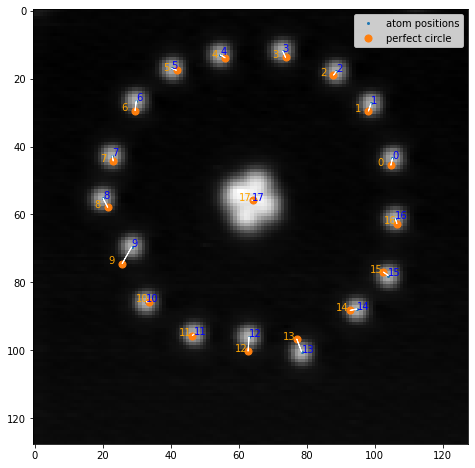

In [21]:
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)
applied_rotation, centroids_3D = minimize_manipulation_distance(CC, C, lattice_discretized_circle, center, dispmat)

28 70 26 74


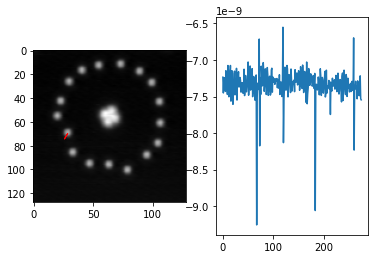

63 96 63 100


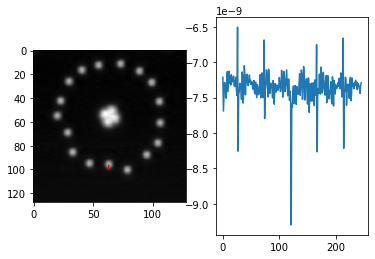

78 100 77 97


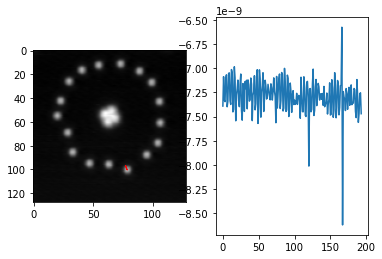

In [22]:
# set lateral manipulation parameters
# note: for manipulation of Co atoms on Ag(111), better precision is achieved by using 10mV manipulation "regime" rather than 2.6V
latman_millivolt = 2 #5
latman_picoamp = 72000 #88000

# read tip offset and image size
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# bias for scanning (mV)
scan_bias_mv = 1000

# for each "atom" in the image
for n in range(len(centroids_3D)-1):
    initial = pixel_to_nm(centroids_3D[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])

    dist_to_perfect = C.pix_to_nm(np.linalg.norm(np.array(applied_rotation[n])-np.array(centroids_3D[n])))
    if dist_to_perfect > 0.4: # nm 
        #print(centroids_3D[n], applied_rotation[n])
        im, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(dispmat);
        ax1.arrow(*centroids_3D[n], *(np.array(applied_rotation[n])-np.array(centroids_3D[n])), color='red')


        # documentation in AMRL/Environment/createc_control.py
        latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
        ax2.plot(latmandata.current)
        plt.show()
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()
# todo: plot and save data from these manipulations 